# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Exploratory Data Analysis
In this notebook we will perform Exploratory Data Analysis. The goal of this notebook is to take a closer look at our data and see if we can extract any insights from it. The questions we would like to answer by the end of this notebook are:<br>
<ul><i>What is the biggest token in terms of total market capitalization?<br>
    What is the biggest token in terms of trading volume?<br>
    What token has the highest price?<br>
    What token shows the highest ROI?<br>
    Is there any intercorrelation between tokens' prices?<br>
    What are the summary statistics for each coin and for all coins combined?<br>
    What features are correlated with each other?<br>
    What is the nature of this correlation?</i><br>
</ul>
This is not a complete list by any means. During our analysis we will come up with some other quiestions and we will answer them right away. <br>
Let's start.

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from functools import reduce
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from scipy.stats import linregress
# warnings.filterwarnings('ignore')

#setting default figure size
sns.set(rc={"figure.figsize":(12, 5)})
plt.rcParams['figure.figsize'] = (12, 5)

sns.set_style('whitegrid')

#showing only 2 decimals for floats
pd.options.display.float_format = "{:.3f}".format

In [2]:
df = pd.read_csv('../DW/Data_for_EDA.csv')

### Data Overview

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7976 entries, 0 to 7975
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        7976 non-null   datetime64[ns]
 1   Coin        7976 non-null   object        
 2   Open        7976 non-null   float64       
 3   High        7976 non-null   float64       
 4   Low         7976 non-null   float64       
 5   Close       7976 non-null   float64       
 6   Volume      7976 non-null   float64       
 7   Market_Cap  7976 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 498.6+ KB


As we know from the Data Wrangling step, we don't have any missing values, out dates are Datetime objects and the numbers are floats. Now, let's see the period our data spans for and take a look at the summary statistics for each of the tokens.

In [5]:
print(df['Date'].min())
print(df['Date'].max())

2015-08-06 00:00:00
2021-01-24 00:00:00


The earliest observation we have was made on August 6, 2015. The latest one was made on January 24, 2021. Now let's take a look at the summary statistics.

In [6]:
df.describe()

,Open,High,Low,Close,Volume,Market_Cap
count,7976.000,7976.000,7976.000,7976.000,7976.000,7976.000
mean,1565.320,1608.040,1521.382,1569.935,4629692633.608,17179121766.594
std,3790.603,3911.309,3664.987,3810.128,9101271299.228,35702661898.988
min,0.004,0.004,0.004,0.004,24818.000,0.000
25%,0.904,0.934,0.861,0.902,50832325.000,217416005.712
50%,60.282,61.927,58.338,60.288,993086852.000,3459855932.916
75%,455.869,466.313,448.114,457.203,4430225205.250,17213261509.718
max,40788.641,41946.738,38980.875,40797.609,123320567398.000,329315720181.841


We can see from the statistics above that 'total_volume' and 'market_cap' are quite huge. To make it easier for observing we will add two columns with volume values shown <b>in millions</b> and market_cap values shown <b>in billions</b>

In [7]:
#volume in millions
df['Volume_Mil'] = df['Volume'] / 1000000

#market capitalization in billions
df['Market_Cap_Bil'] = df['Market_Cap'] / 1000000000

In [8]:
col = df.pop("Volume_Mil")
df.insert(7, col.name, col)

In [9]:
df.sort_values(by='Date')
df.head()

,Date,Coin,Open,High,Low,Close,Volume,Volume_Mil,Market_Cap,Market_Cap_Bil
0,2021-01-24,BTC,31794.328,32938.766,31106.686,31786.879,46807683072.000,46807.683,112970698851.375,112.971
1,2021-01-19,BTC,36642.234,37755.891,36069.805,36069.805,57244195486.000,57244.195,109372673141.740,109.373
2,2021-01-18,BTC,35792.238,37299.285,34883.844,36630.074,49511702429.000,49511.702,108845285496.567,108.845
3,2021-01-17,BTC,36163.648,36722.352,34069.320,35791.277,52359854336.000,52359.854,108155761830.830,108.156
4,2021-01-16,BTC,36821.648,37864.367,35633.555,36178.141,57706187875.000,57706.188,113987017102.366,113.987


Now we'll take a look at the summary statistics of each coin.<br>
#### NOTE: IT IS IMPORTANT TO MENTION THAT THE DATA WAS AQUIRED FROM ONE PARTICULAR CRYPTO EXCHANGE SO IT MAY VARY FROM OTHER EXCHANGES AND AGGREGATORS. WE WILL PERFROM ANALYSIS BASED ON THE DATA AQUIRED FROM COINGECKO.COM

In [10]:
coins = ['BTC', 'ETH', 'XRP', 'LTC']
btc = df[df['Coin'] == 'BTC']
eth = df[df['Coin'] == 'ETH']
xrp = df[df['Coin'] == 'XRP']
ltc = df[df['Coin'] == 'LTC']

In [11]:
dfs = [btc, eth, xrp, ltc]
for daf, coin in zip(dfs, coins):
    print(f'===== Summary statistics for {coin} =====')
    print(daf.describe())
    print('')

===== Summary statistics for BTC =====
           Open      High       Low     Close           Volume  Volume_Mil  \
count  1994.000  1994.000  1994.000  1994.000         1994.000    1994.000   
mean   5975.166  6135.391  5810.836  5992.917  11164786414.986   11164.786   
std    5608.986  5811.320  5396.204  5647.920  14510817602.125   14510.818   
min     210.068   226.321   199.567   210.495     12712600.000      12.713   
25%     780.214   789.472   777.842   782.338    136143748.000     136.144   
50%    5930.529  6181.520  5736.933  5940.195   4792939920.000    4792.940   
75%    9099.508  9275.235  8854.203  9121.662  18104875672.500   18104.876   
max   40788.641 41946.738 38980.875 40797.609 123320567398.000  123320.567   

            Market_Cap  Market_Cap_Bil  
count         1994.000        1994.000  
mean   36569377576.845          36.569  
std    58945052342.325          58.945  
min      771368060.000           0.771  
25%     4306778397.694           4.307  
50%     7902

Great. Now it's much easier to see the trading volume and market capitalization of each token. Now we have all the data needed to proceed and answer our questions from the beginning of the notebook.<br>
First we will find out how coin prices changed in 2020.

In [12]:
start_date = '2019-12-31'
end_date = '2020-12-31'
mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
df_2020 = df.loc[mask]

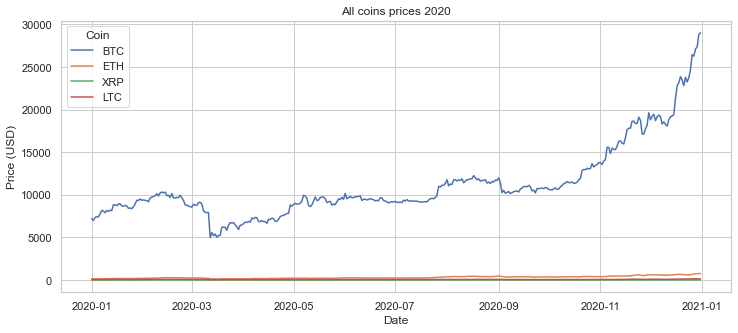

In [13]:
sns.lineplot(data=df_2020, x='Date', y='Close', hue='Coin')
plt.title('All coins prices 2020')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

We can barely see ETH, XRP and LTC on the graph, because their prices are very small compared to BTC. Let's take a look at their graphs without BTC.

In [14]:
mask = (df_2020['Coin'] != 'BTC')
df_2020_noBTC = df_2020[mask]

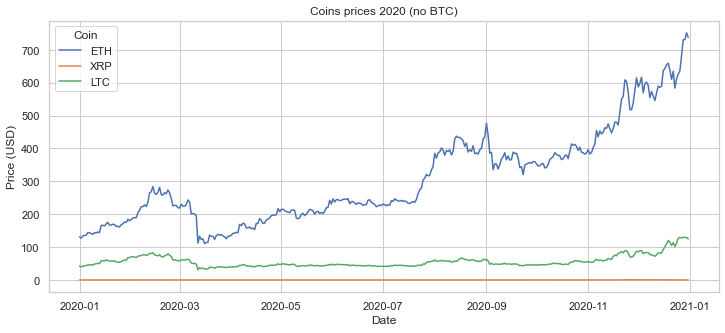

In [15]:
sns.lineplot(data=df_2020_noBTC, x='Date', y='Close', hue='Coin')
plt.title('Coins prices 2020 (no BTC)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Again, XRP's price is shown to be around zero. Let's now take a look at every coin's price on the separate chart.

In [16]:
BTC_2020 = df_2020[df_2020['Coin'] == 'BTC']
ETH_2020 = df_2020[df_2020['Coin'] == 'ETH']
XRP_2020 = df_2020[df_2020['Coin'] == 'XRP']
LTC_2020 = df_2020[df_2020['Coin'] == 'LTC']
dfs_2020 = [BTC_2020, ETH_2020, XRP_2020, LTC_2020]
colors = ['gold', 'purple', 'black', 'blue']

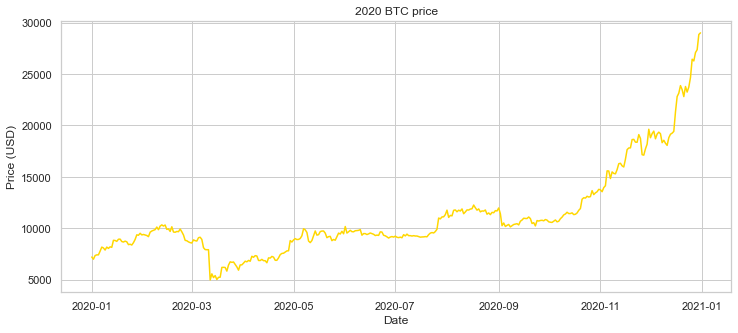

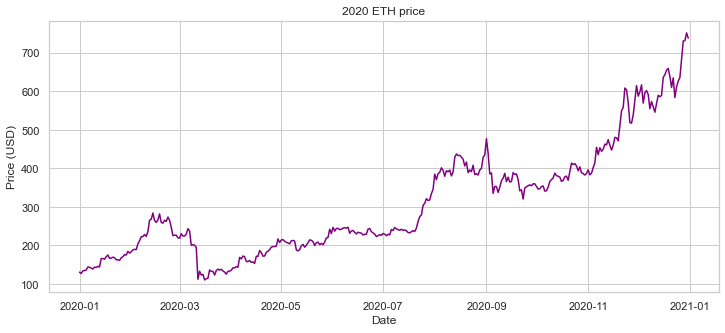

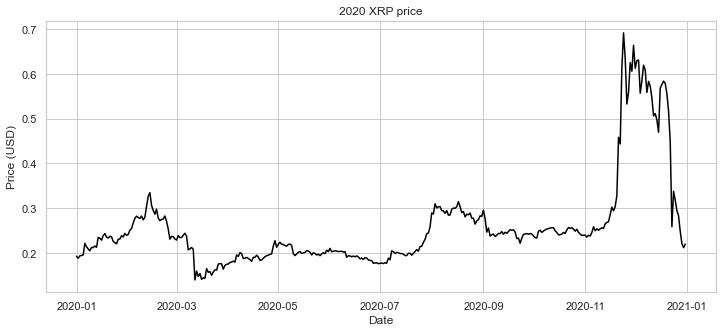

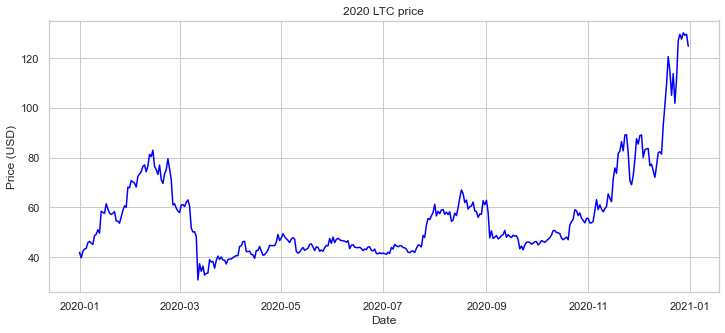

In [17]:
for daf, coin, color in zip(dfs_2020, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Close', color=color)
    plt.title(f'2020 {coin} price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show();

We see that BTC, ETH and LTC have very similar patterns and they all started fast growth in the 4th quarter of 2020. XRP, however, is an ourlier here. It started exponential growth in november 2020 and reached 0.7USD per coin but then rapidly crashed to 0.2USD per coin. Why did that happen?<br>
For everyone who were following Ripple XRP it's quite clear - on December 22, 2020 US Securities and Exchange Comission filed several lawsuited against Ripple (the company which created XRP) and two of its execitives with conducting 1.3 billion dollars unregistered securities offering. No wonder investors started to quickly sell of their XRPs and the price went down pretty dramatically.<br>
BTC, ETH and LTC, as I mentioned before, look similar. But this is only for 2020. Are they also similar if we look at the broader picture? Let's find out.

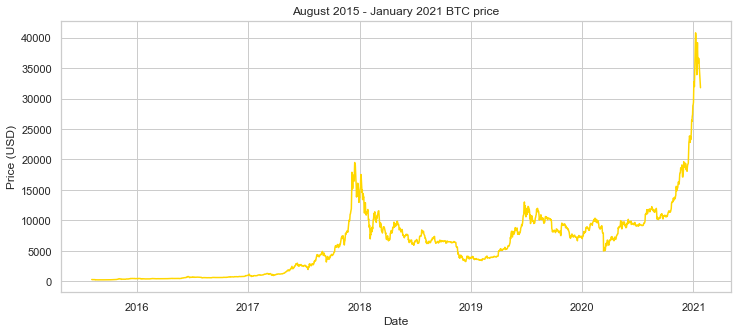

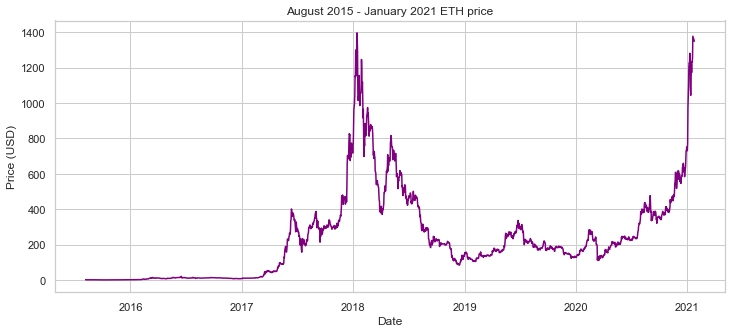

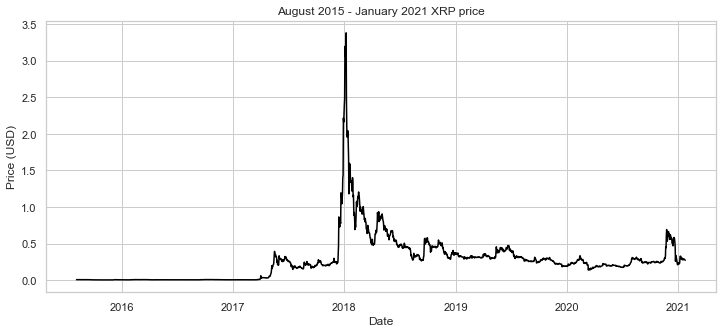

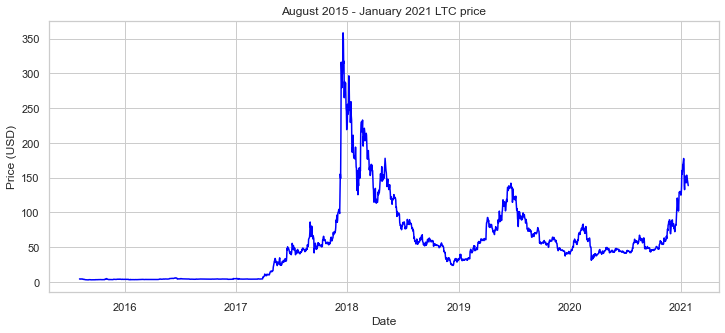

In [18]:
for daf, coin, color in zip(dfs, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Close', color=color)
    plt.title(f'August 2015 - January 2021 {coin} price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show();

We would like to make some notes here:<br>
1) Bitcoin is the first and biggest cryptocurrency. Historically, all other cryptocurrencies are called "Altcoins". In our example ETH, XRP and LTC are altcoins.<br>
2) From the graphs we can tell that all four cryptocurrencies have very similar pattern *until* the end of 2020. We should find out why.

Now we will take a look at the coin's total market cap in 2020.

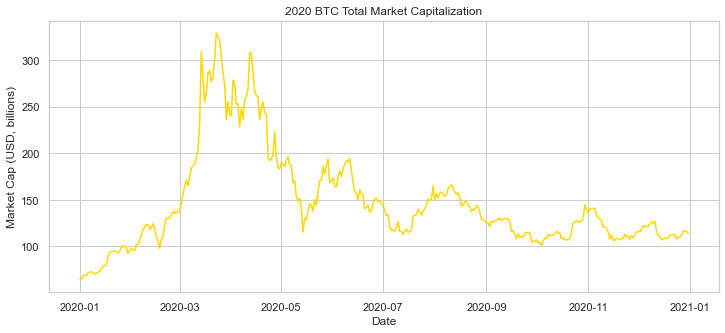

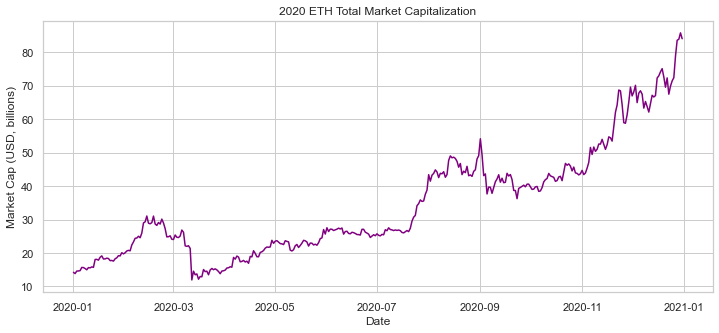

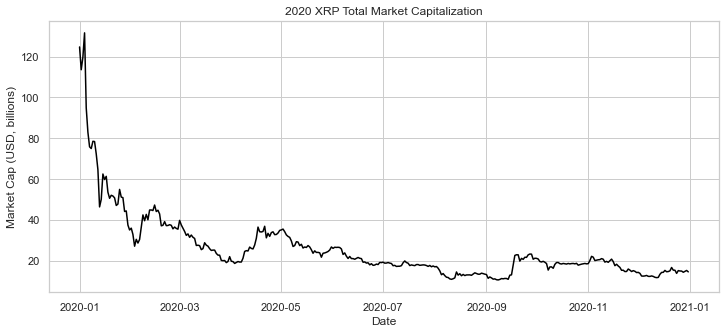

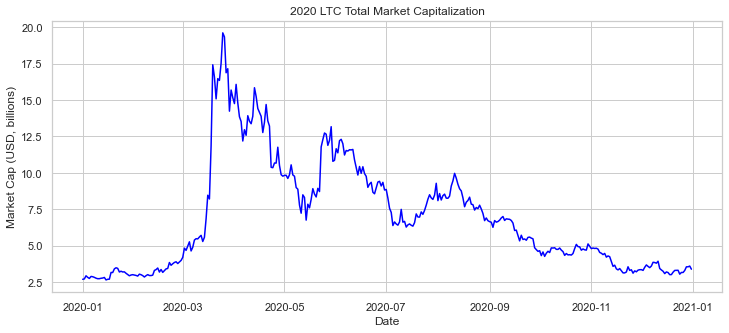

In [19]:
for daf, coin, color in zip(dfs_2020, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Market_Cap_Bil', color=color)
    plt.title(f'2020 {coin} Total Market Capitalization')
    plt.xlabel('Date')
    plt.ylabel('Market Cap (USD, billions)')
    plt.show();

Again, all coins look very similar in terms of the pattern, except for ETH, that shown consistent growth ove the whole year. We would probably expect the patterns to be similar for 2015-2021 period too.

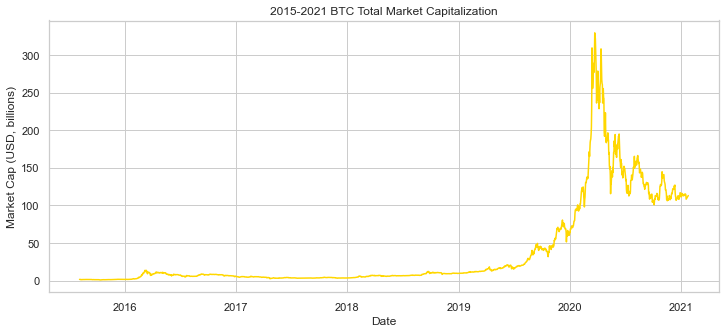

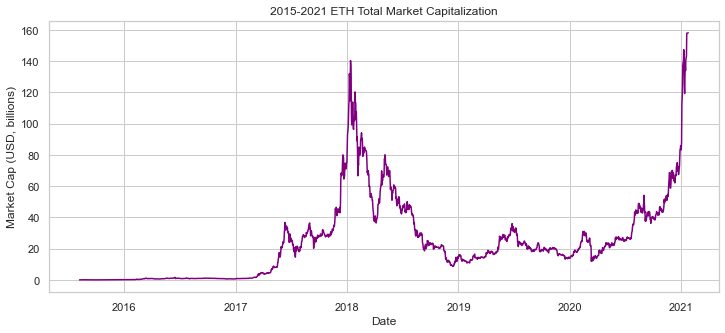

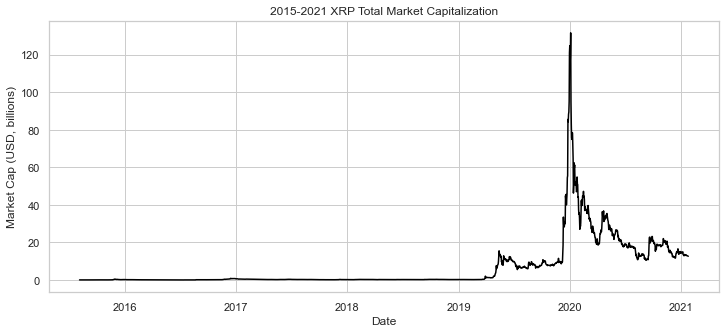

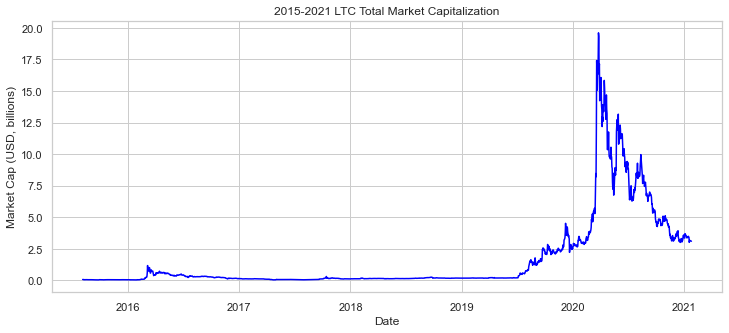

In [20]:
for daf, coin, color in zip(dfs, coins, colors):
    sns.lineplot(data=daf, x='Date', y='Market_Cap_Bil', color=color)
    plt.title(f'2015-2021 {coin} Total Market Capitalization')
    plt.xlabel('Date')
    plt.ylabel('Market Cap (USD, billions)')
    plt.show();

In [21]:
start_date_filt = '2017-12-31'
end_date_filt = '2018-12-31'
filt = (df['Date'] > start_date_filt) & (df['Date'] <= end_date_filt)

In [22]:
xrp_filt = xrp.loc[filt]

In [23]:
xrp_filt

,Date,Coin,Open,High,Low,Close,Volume,Volume_Mil,Market_Cap,Market_Cap_Bil
4738,2018-12-31,XRP,0.371,0.374,0.351,0.353,501793515.000,501.794,232013651.874,0.232
4739,2018-12-30,XRP,0.365,0.371,0.362,0.370,486955034.000,486.955,229252017.177,0.229
4740,2018-12-29,XRP,0.378,0.384,0.367,0.367,617892296.000,617.892,231686616.186,0.232
4741,2018-12-28,XRP,0.342,0.379,0.339,0.377,765420103.000,765.420,235720056.336,0.236
4742,2018-12-27,XRP,0.379,0.380,0.336,0.341,575821046.000,575.821,233721504.910,0.234
...,...,...,...,...,...,...,...,...,...,...
5098,2018-01-05,XRP,3.301,3.565,2.826,3.049,6288500224.000,6288.500,201056952.398,0.201
5099,2018-01-04,XRP,3.117,3.842,3.117,3.197,8103660032.000,8103.660,199245930.642,0.199
5100,2018-01-03,XRP,2.464,3.279,2.443,3.105,6635879936.000,6635.880,201492939.117,0.201
5101,2018-01-02,XRP,2.369,2.489,2.248,2.481,3171010048.000,3171.010,201492939.117,0.201


Indeed, patterns are again extremely similar. Common sense tells us that the prices/market cap of ETH, XRP and LTC are strongly correlated with those of BTC.

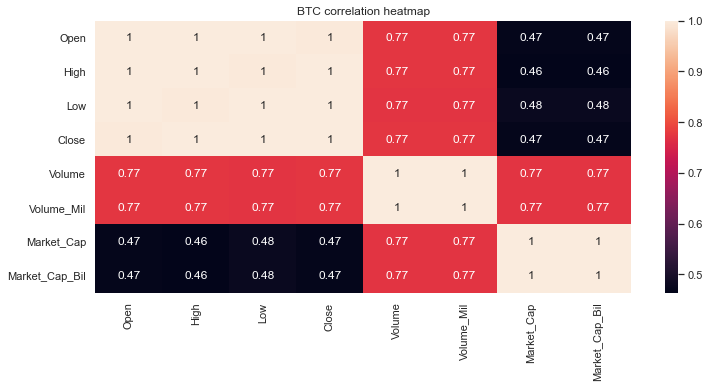

In [24]:
btc_corr = btc.corr()
sns.heatmap(btc_corr, annot=True)
plt.title('BTC correlation heatmap')
plt.show();

We can see from the heatmap that 'Open', 'High', 'Low' and 'Close' are redundant for our analysis since they all have correlation of 1 with each other. For our next steps we will only keep 'Close' feature. 'Market_Cap' and 'Volume' features have, of course, perfect correlation with 'Market_Cap_Bil' and 'Volume_Mil' respectively.

In [25]:
btc_for_corr = btc[['Close', 'Volume_Mil', 'Market_Cap_Bil']]
btc_corr = btc_for_corr.corr()

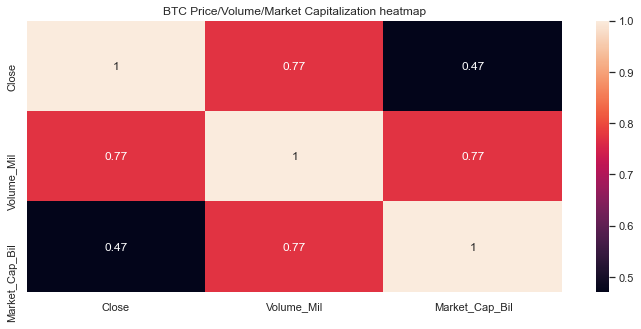

In [26]:
sns.heatmap(btc_corr, annot=True)
plt.title('BTC Price/Volume/Market Capitalization heatmap')
plt.show();

'Close' is strongly correlated with volume and moderately correlated with market cap. 'Volume' and 'Market Cap' are also strongly correlated with each other.

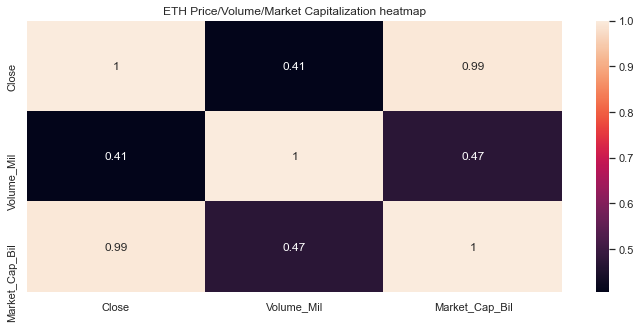

In [27]:
eth_for_corr = eth[['Close', 'Volume_Mil', 'Market_Cap_Bil']]
eth_corr = eth_for_corr.corr()
sns.heatmap(eth_corr, annot=True)
plt.title('ETH Price/Volume/Market Capitalization heatmap')
plt.show();

For ETH, 'Close' has small correlation with Market Cap and medium correlation with Volume. 'Market_Cap_Bil' and 'Volume_Mil' has high intercorrelation.

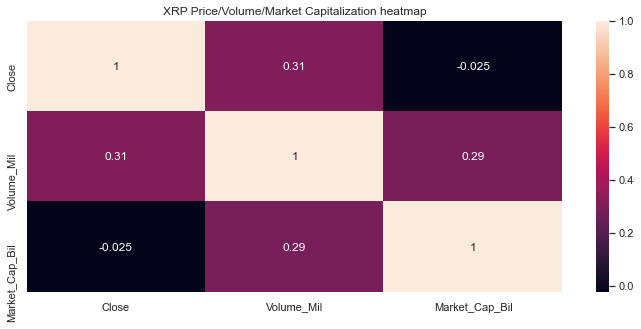

In [28]:
xrp_for_corr = xrp[['Close', 'Volume_Mil', 'Market_Cap_Bil']]
xrp_corr = xrp_for_corr.corr()
sns.heatmap(xrp_corr, annot=True)
plt.title('XRP Price/Volume/Market Capitalization heatmap')
plt.show();

Here we see very small negative correlation between 'Close' and 'Market_Cap_Bil' and small positive correlation between 'Volume_Mil' and 'Market_Cap_Bil'(0.29) and between 'Close' and 'Volume_Mil'

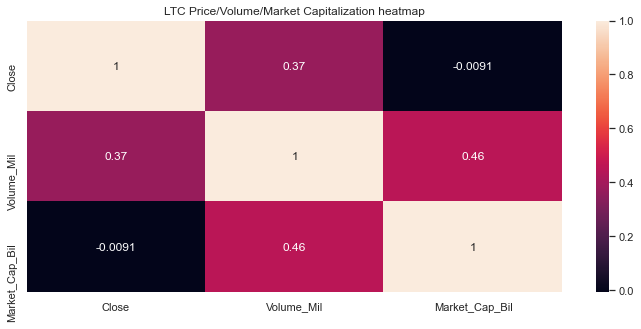

In [29]:
ltc_for_corr = ltc[['Close', 'Volume_Mil', 'Market_Cap_Bil']]
ltc_corr = ltc_for_corr.corr()
sns.heatmap(ltc_corr, annot=True)
plt.title('LTC Price/Volume/Market Capitalization heatmap')
plt.show();

The pattern for LTC is similar to the one of XRP, but 'Volume_Mil' and 'Market_Cap_Bil' have medium correlation with each other.

Now, it would be interesting to see how those features are correlated between different coins.

In [30]:
corr_dfs = [btc_for_corr, eth_for_corr, xrp_for_corr, ltc_for_corr]
date_ser = df['Date']
suffixes = ['_BTC', '_ETH', '_XRP', '_LTC']

In [31]:
for daf in corr_dfs:
    daf.insert(loc=0, column='Date', value=date_ser)

In [32]:
#adding suffixes for better interpretability of the correlation heatmap
for daf, suf in zip(corr_dfs, suffixes):
    daf.columns=daf.columns.map(lambda col : col+suf if col != 'Date' else col)
for daf in corr_dfs:
    print(df.columns)

Index(['Date', 'Coin', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Mil',
       'Market_Cap', 'Market_Cap_Bil'],
      dtype='object')
Index(['Date', 'Coin', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Mil',
       'Market_Cap', 'Market_Cap_Bil'],
      dtype='object')
Index(['Date', 'Coin', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Mil',
       'Market_Cap', 'Market_Cap_Bil'],
      dtype='object')
Index(['Date', 'Coin', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Mil',
       'Market_Cap', 'Market_Cap_Bil'],
      dtype='object')


In [33]:
#merging correlation dataframes into one
df_merged = reduce(lambda left,right: pd.merge(left,right,on=['Date'], how='outer'), corr_dfs)

In [34]:
df_merged.columns

Index(['Date', 'Close_BTC', 'Volume_Mil_BTC', 'Market_Cap_Bil_BTC',
       'Close_ETH', 'Volume_Mil_ETH', 'Market_Cap_Bil_ETH', 'Close_XRP',
       'Volume_Mil_XRP', 'Market_Cap_Bil_XRP', 'Close_LTC', 'Volume_Mil_LTC',
       'Market_Cap_Bil_LTC'],
      dtype='object')

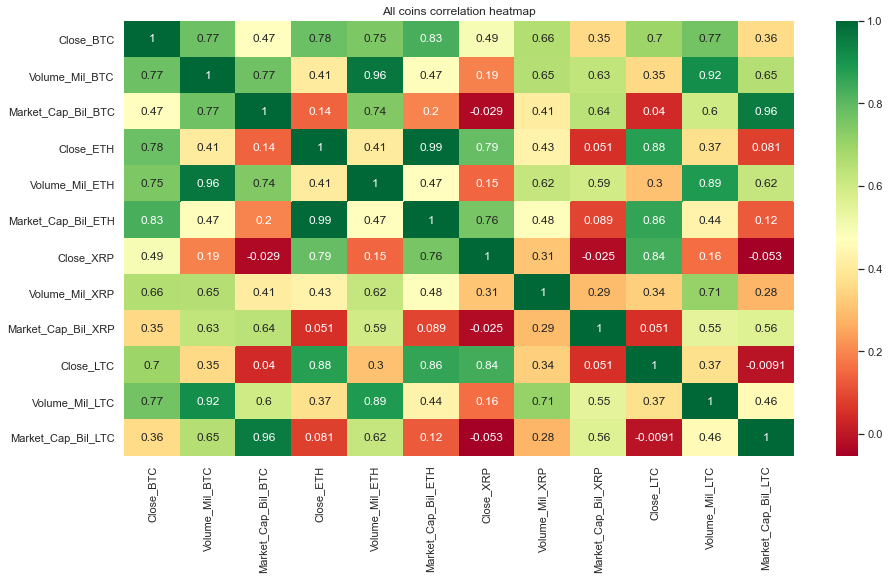

In [35]:
#correlation heatmap for different coins
df_merged_corr = df_merged.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(df_merged_corr, annot=True, cmap='RdYlGn')
plt.title('All coins correlation heatmap')
plt.show();

In [36]:
df_merged_corr

,Close_BTC,Volume_Mil_BTC,Market_Cap_Bil_BTC,Close_ETH,Volume_Mil_ETH,Market_Cap_Bil_ETH,Close_XRP,Volume_Mil_XRP,Market_Cap_Bil_XRP,Close_LTC,Volume_Mil_LTC,Market_Cap_Bil_LTC
Close_BTC,1.000,0.774,0.470,0.781,0.753,0.829,0.495,0.658,0.354,0.696,0.769,0.359
Volume_Mil_BTC,0.774,1.000,0.772,0.407,0.964,0.468,0.190,0.651,0.630,0.355,0.917,0.653
Market_Cap_Bil_BTC,0.470,0.772,1.000,0.142,0.742,0.196,-0.029,0.412,0.640,0.040,0.597,0.957
Close_ETH,0.781,0.407,0.142,1.000,0.405,0.994,0.786,0.433,0.051,0.876,0.372,0.081
Volume_Mil_ETH,0.753,0.964,0.742,0.405,1.000,0.471,0.147,0.621,0.595,0.303,0.889,0.618
Market_Cap_Bil_ETH,0.829,0.468,0.196,0.994,0.471,1.000,0.758,0.481,0.089,0.857,0.435,0.125
Close_XRP,0.495,0.190,-0.029,0.786,0.147,0.758,1.000,0.309,-0.025,0.839,0.158,-0.053
Volume_Mil_XRP,0.658,0.651,0.412,0.433,0.621,0.481,0.309,1.000,0.291,0.335,0.709,0.279
Market_Cap_Bil_XRP,0.354,0.630,0.640,0.051,0.595,0.089,-0.025,0.291,1.000,0.051,0.547,0.564
Close_LTC,0.696,0.355,0.040,0.876,0.303,0.857,0.839,0.335,0.051,1.000,0.372,-0.009


In [37]:
#looking at the price correlation between different coins
close_cols = [col for col in df_merged.columns if 'Close' in col]
for col in close_cols:
    print('==========', col, '===========')
    print(df_merged_corr[col].sort_values(ascending=False))

========== Close_BTC ===========
Close_BTC            1.000
Market_Cap_Bil_ETH   0.829
Close_ETH            0.781
Volume_Mil_BTC       0.774
Volume_Mil_LTC       0.769
Volume_Mil_ETH       0.753
Close_LTC            0.696
Volume_Mil_XRP       0.658
Close_XRP            0.495
Market_Cap_Bil_BTC   0.470
Market_Cap_Bil_LTC   0.359
Market_Cap_Bil_XRP   0.354
Name: Close_BTC, dtype: float64
========== Close_ETH ===========
Close_ETH            1.000
Market_Cap_Bil_ETH   0.994
Close_LTC            0.876
Close_XRP            0.786
Close_BTC            0.781
Volume_Mil_XRP       0.433
Volume_Mil_BTC       0.407
Volume_Mil_ETH       0.405
Volume_Mil_LTC       0.372
Market_Cap_Bil_BTC   0.142
Market_Cap_Bil_LTC   0.081
Market_Cap_Bil_XRP   0.051
Name: Close_ETH, dtype: float64
========== Close_XRP ===========
Close_XRP             1.000
Close_LTC             0.839
Close_ETH             0.786
Market_Cap_Bil_ETH    0.758
Close_BTC             0.495
Volume_Mil_XRP        0.309
Volume_Mil_BTC       

As we can see from the heatmap and the list of correlations, all coins' prices are highly correlated with each other. It makes sense, and if we take a look at the price charts we will see that altcoins' prices usually closely follow BTC price with some short time lag. 

### AUTOCORRELATION AND STATIONARITY

#### From here we will focus on BTC price and perform analysis just for this coin. Then we will extend it to other three coins.

<b>Autocorrelation</b> is a type of serial dependence when a time series is linearly related to a lagged version of itself.<br>
Why is it important? A lot of time-series forecasting algorithms are based on regression analysis. One of the assumptions we make before peprforming regression analysis is that the data has no autocorrelation. However, if it actually does, then our analysis will be incorrect and misleading.<br>
<b>Stationarity</b> means that the statistical properties of a process generating a time series do not change over time.<br>
Wht is it important? Stationary processes are possible to predict since the way they change is the same over the period of time. The processes themselves might change, but the way they change is constant, making it easier to model.<br>
<br>
We will now use pandas autocorr method to find out Pearson's correlation coefficient - basically, a normalized measurment of covariance, range from -1(perfect negative correlation) to 1(perfect postivie correlation) - and then plot a corellogram (autocorellation function values) of BTC price and see if the process is stationary.

In [38]:
BTC_price = btc['Close']

In [39]:
print(BTC_price.autocorr())

0.9976758642885858


The coefficient of 0.997 clearly shows that BTC price is strongly autocorrelated. Let's plot the ACF now.

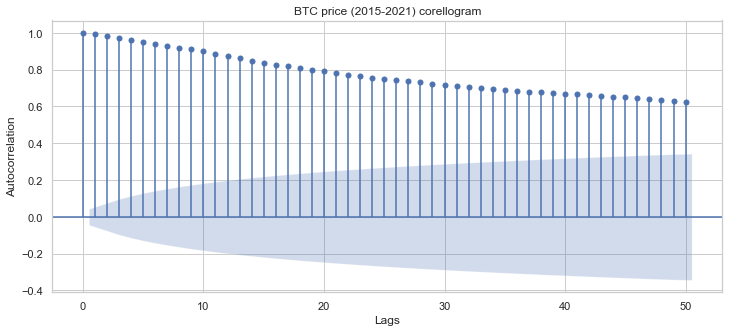

In [40]:
plot_acf(BTC_price, lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('BTC price (2015-2021) corellogram')
plt.show();

For a stationary process we would expect to see the values of autocorrelation to degrade to zero quickly. However, we don't see it on the plot, and thus we can assume that the process of BTC pricing is not stationary.<br>
Now, let's perform <b>Augmented Dickey-Fuller(ADF)</b> test and make sure that our process is not stationary. The null hypothesis in this test is that a unit root is present in an autoregressive model, and that the process is thus not stationary.<br>
The <b>ADF statistic</b>, used in the test, is a negative number. The <i>more negative</i> it is, the <i>stronger</i> the rejection of the null hypothesis.

In [41]:
result = adfuller(BTC_price)
print('ADF statistic is:', result[0])

ADF statistic is: -3.520942816568193


We can see that the ADF statistic is -3.5. We can confidently reject the null hypothesis. The test just confirmed our assumption that the process of BTC pricing <b>IS NOT stationary</b>.

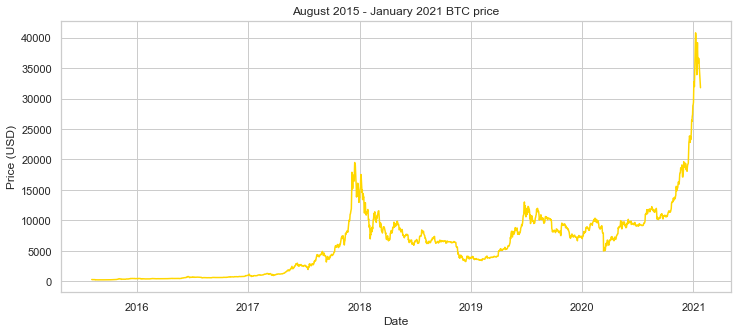

In [42]:
sns.lineplot(data=btc, x='Date', y='Close', color='Gold')
plt.title(f'August 2015 - January 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

Although we don't necessarily see any seasonality, we can clearly see an upward trend.

### HYPOTHESIS TESTING

For those who are familiar with stock market and know what stock price charts look like, those graphs above should seem very close to what you can see in stock market. We need to introduce an important term here - random walk - because we want to find out if our crypto coins prices are random walks or not.<br> 
<b>Random Walk</b> - mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.<br>
In other words, we would like to find out if the prices are random or not, because if they are indeed random walks then there is no way we can predict them.<br>

We will now formulate hypothesis - null and alternative.<br>
    <b>Null hypothesis</b> - BTC price <b>IS</b> random walk. Best prediction for its price tomorrow in this case is today's price, because in random walk tomorrow's price = today's price + some white noise.<br>
    <b>Alternative hypothesis</b> - BTC price <b>IS NOT</b> random walk. We will then be able to use time-series forcasting algorithms to predict BTC tomorrow's price.<br>
    In order to find out if our Null hypothesis is correct or not we will perform <b>Augmented Dickey-Fuller Test</b> which is available in statsmodel module for Python. We will not describe the idea of the test here and will just mention that if the p-value will be less than 0.05 then we will be able to reject our Null Hypothesis.

In [43]:
res_norm = adfuller(BTC_price.dropna())
print('p-value is:', res_norm[1],)

p-value is: 0.007465249080685513


p-value for BTC is 0.007, which is significantly less than the treshold of 0.05. We can <b>confidently reject</b> the null hypothesis. BTC pricing process <b>IS NOT</b> random walk, which means we will be able to use time series forecasting algorithms in order to predict its future values.

In [44]:
#saving the data
datapath = 'D://Prog/SDST/My Projects/Capstone3/EDA'
if not os.path.exists(datapath):
    os.mkdir(datapath)
datapath_EDA = os.path.join(datapath, 'Data_for_PTDD.csv')
if not os.path.exists(datapath_EDA):
    df.to_csv(datapath_EDA, index=False)
df_merged.to_pickle("./df_merged.pkl")
for df, coin in zip(dfs, coins):
    df.to_pickle(f'./{coin}.pkl')